In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from __future__ import print_function, division 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import time 
import shutil
import copy 
from PIL import Image
from tqdm.auto import tqdm


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Load Data

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


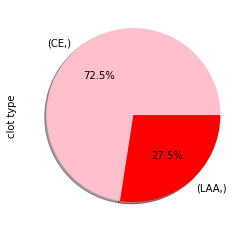

In [2]:
df_train = pd.read_csv("../input/mayo-clinic-strip-ai/train.csv")
display(df_train.head())
colors = ['#ffc0cb','#ff0000']
fig = df_train[["label"]].value_counts().plot.pie(autopct='%1.1f%%', 
                                                  ylabel="clot type", 
                                                  colors = colors, 
                                                  shadow = True)

In [3]:
DATASET_FOLDER = "../input/mayo-clinic-strip-ai"
df_train = pd.read_csv("../input/mayo-clinic-strip-ai/train.csv")


Image.MAX_IMAGE_PIXELS = 5_000_000_000

sizes = []
for name in tqdm(df_train["image_id"]):
    img = Image.open(os.path.join(DATASET_FOLDER, "train", f"{name}.tif"))
    sizes.append({"img_height": img.height, "img_width": img.width})

df_sizes = pd.DataFrame(sizes)
for col in df_sizes.columns:
    df_train[col] = df_sizes[col]
    
df_train["pixels"] = df_train["img_width"] * df_train["img_height"]
df_train.sort_values("pixels", inplace=True)
display(df_train.head())

  0%|          | 0/754 [00:00<?, ?it/s]

,image_id,center_id,patient_id,image_num,label,img_height,img_width,pixels
522,b43ebe_0,7,b43ebe,0,CE,5314,4417,23471938
154,32e44f_0,11,32e44f,0,CE,4470,7814,34928580
110,244aeb_1,4,244aeb,1,LAA,5398,6540,35302920
111,244aeb_2,4,244aeb,2,LAA,5230,6880,35982400
109,244aeb_0,4,244aeb,0,LAA,4977,7814,38890278


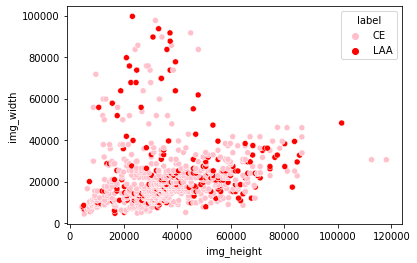

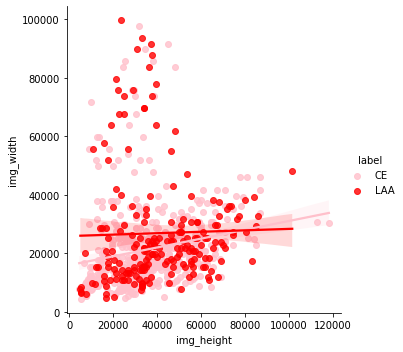

In [4]:
import seaborn as sns
sns.scatterplot(x=df_train['img_height'], 
                y=df_train['img_width'], 
                hue=df_train['label'], 
                palette=colors)
sns.lmplot(x="img_height", 
           y="img_width", 
           hue="label", 
           data=df_train, 
           palette=colors)

Class imbalances are clear in the graphs. Thus, we need to implement oversampling in the training step. 

# Image Vis

In [6]:
metadata = pd.read_csv("../input/mayo-clinic-strip-ai/train.csv")
img_id = metadata.iloc[:, 0]
labels = metadata.iloc[:, 4]
id_to_lbl = pd.concat([img_id, labels], axis = 1)
id_to_lbl.set_index('image_id')
id_to_lbl = id_to_lbl.to_dict()

In [7]:
#from jirkaborovec/bloodclots-eda-load-wsi-prune-background 
def prune_image_rows_cols(im, mask, thr=0.990):
    # delete empty columns
    for l in reversed(range(im.shape[1])):
        if (np.sum(mask[:, l]) / float(mask.shape[0])) > thr:
            im = np.delete(im, l, 1)
    # delete empty rows
    for l in reversed(range(im.shape[0])):
        if (np.sum(mask[l, :]) / float(mask.shape[1])) > thr:
            im = np.delete(im, l, 0)
    return im


def mask_median(im, val=255):
    masks = [None] * 3
    for c in range(3):
        masks[c] = im[..., c] >= np.median(im[:, :, c]) - 5
    mask = np.logical_and(*masks)
    im[mask, :] = val
    return im, mask

In [9]:
!rm -rf conda-pkgs
!mkdir conda-pkgs
 # Set the location where conda package will be downloaded
!conda config --add pkgs_dirs ./conda-pkgs
 # Download pyvips and dependencies
!conda install --download-only -y "pyvips>=2.2.0"
!rm -rf ./conda-pkgs/cache

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pyvips[version='>=2.2.0']


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-cpp-1.74.0           |       h75c5d50_8        16.2 MB  conda-forge
    cfitsio-4.1.0              |       hd9d235c_0         1.3 MB  conda-forge
    glib-2.72.1                |       h6239696_0         443 KB  conda-forge
    glib-tools-2.72.1          |       h6239696_0         107 KB  conda-forge
    gstreamer-orc-0.4.32       |       h7f98852_1         267 KB  conda-forge
    hdf5-1.12.1                |nompi_h2386368_104         3.5 MB  conda-forge
    libexif-0.6.21             |       h7f98852_0         992 KB  conda-forge
    libgsf-1.14.50             |       he99f2b3_0         460 KB  conda-forge
    libmatio-1.5.21            |       hdf44fe6_1         285 KB  conda-forge
    libvips

In [11]:
!conda install ./conda-pkgs/*.tar.bz2 --offline


######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
######################################################################## | 100% 
###########################

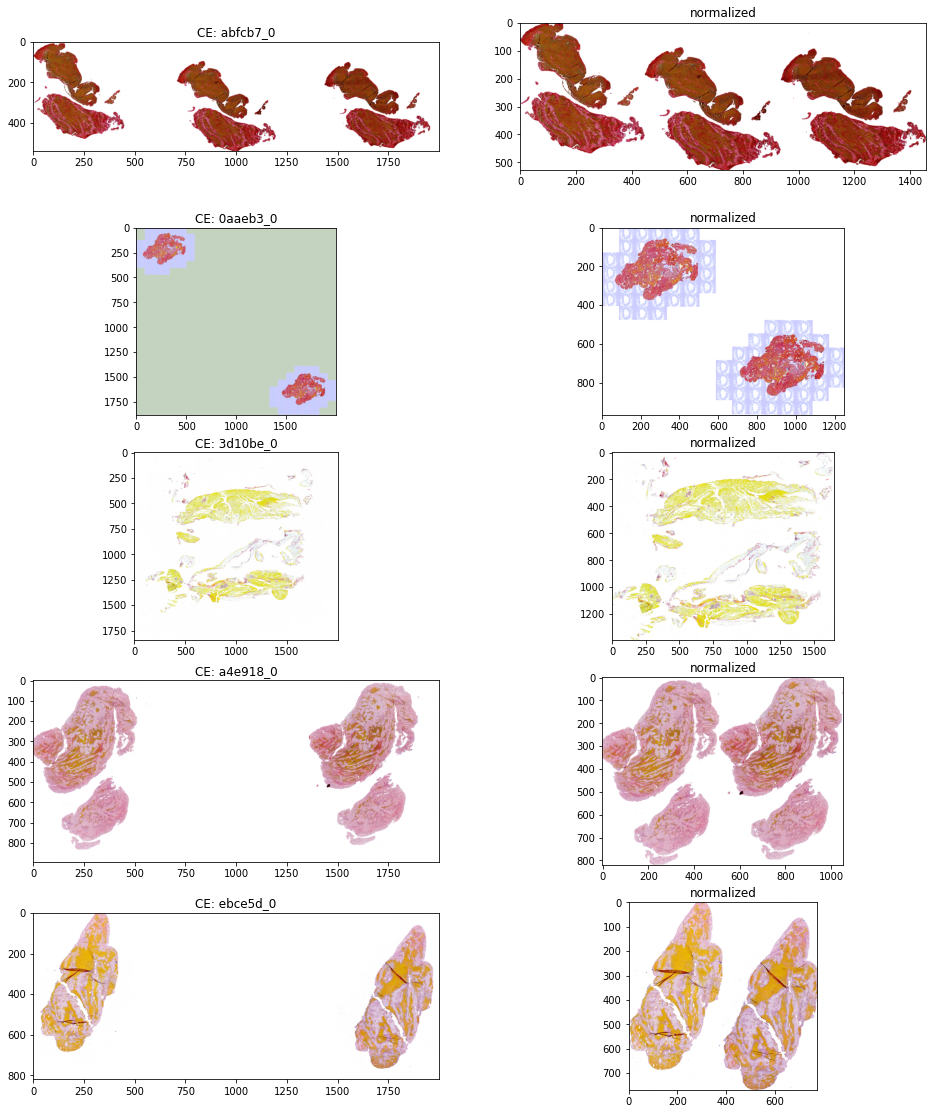

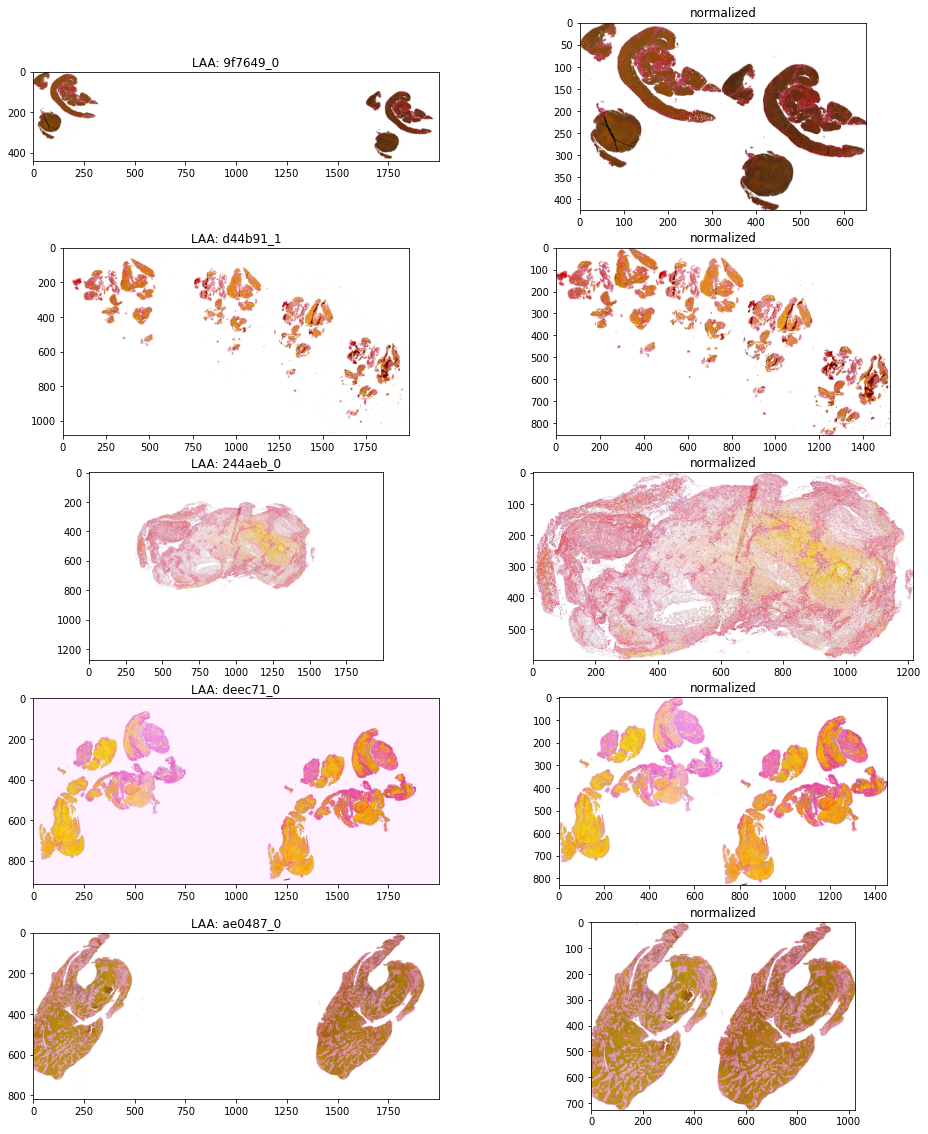

In [12]:
import pyvips

os.environ['VIPS_CONCURRENCY'] = '4'
os.environ['VIPS_DISC_THRESHOLD'] = '8gb'

for lb, dfg in df_train.groupby("label"):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))
    for i, name in enumerate(dfg["image_id"].sample(5)):
        img_path = os.path.join(DATASET_FOLDER, "train", f"{name}.tif")
        # img = Image.open(img_path)
        # for gap see: https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize
        # The smaller reducing_gap, the faster resizing.
        # With reducing_gap greater or equal to 3.0, the result is indistinguishable from fair resampling.
        # The default value for thumbnail() is 2.0, which is very close to fair resampling while still being faster in many cases.
        # UnSupported gap issue: https://github.com/libvips/pyvips/issues/339
        img = pyvips.Image.thumbnail(img_path, 2000).numpy()
        if img.shape[0] > img.shape[1]:
            img = np.rollaxis(img, 0, 2)
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"{lb}: {name}")
        img, mask = mask_median(np.array(img))
        img = prune_image_rows_cols(img, mask)
        #print(clr_mean)
        axes[i, 1].imshow(img)
        axes[i, 1].set_title("normalized")
    fig.show()
del fig, axes, img

# Scaling Down Images 

These tiff files are still very large, even though we've removed the background and pruned empty rows/cols. 

# Transfer Learning: ResNet 

Instead of finetuning all the weights from the pre-trained model, we will instead only keep the pretrained weights from the lowest layers of the model and re-initialize. See https://proceedings.neurips.cc/paper/2019/file/eb1e78328c46506b46a4ac4a1e378b91-Paper.pdf for more.

In [ ]:
image_data = 
dataloader = {x: torch.utils.data.DataLoader(image_data[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train']}
class_names = {'CE': 0, 'LAA': 1}

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25): 
    
    since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  
      else:
        model.eval()   

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()


        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model
    

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

model_ft = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

